# Generation of "Similar" Sentences Using The Variational Auto Encoder

# Introduction

I'm doing a thing to generate similar protein sequences, eventually.

In [1]:
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

from keras.layers import Bidirectional, Dense, Embedding
from keras.layers import Input, Lambda, LSTM, RepeatVector
from keras.layers import Flatten, TimeDistributed, Layer
from keras.layers import Activation, Dropout
from keras.layers.advanced_activations import ELU

from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import objectives

from keras.models import Model

from keras import backend as K
from keras.utils import plot_model

import numpy as np
import pandas as pd

import os
from IPython.display import Image
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Data

### Overview

The dataset consists of roughly 800,000 questions
posted on Quora. This data was made publicly
available via Kaggle at this 
[link](https://www.kaggle.com/quora/question-pairs-dataset).
The original intent of this dataset was to find 
duplicate questions, but it works well for our 
purposes.

### Download

There are multiple ways to download the data. My
preference is to use the kaggle API.

Start by searching for the dataset

```
kaggle datasets list -s quora
```

Once you find the dataset, download it with

```
kaggle datasets download quora/question-pairs-dataset
```

This downloads a zip file. I'm working on 
Ubuntu, so I can unzip with

```
unzip question-pairs-dataset.zip
```

### Preprocess

There is a fair bit of work to be done to preprocess the data. 

### Merge Questions

Because the dataset was originally published
to find duplicates, it has two columns with 
questions. We need to take these columns and
stack them horizontally. 

Worth noting, it's possible there's some
risk of overlapping questions, because some
are semantically duplicative.

In [2]:
project_path = r'/home/das-hund/PycharmProjects/autoencoders'
data_path = os.path.join(project_path, 'data')
question_path = os.path.join(data_path, 'questions.csv')
merged_questions_path = os.path.join(data_path, 'merged.csv')
questions = pd.read_csv(question_path)

questions_one = questions.question1
questions_two = questions.question2

merged = pd.concat([
    questions_one, questions_two
])
merged = merged.sample(frac=1).reset_index(drop=True)
merged.to_csv(
    merged_questions_path,
    index=False, header=False
)

print(f'[+] {len(merged)} questions in {merged_questions_path}.')

print(f'[+] First 5 records of merged questions:')
print(merged.head(5))

del questions, questions_one
del questions_two, merged

[+] 808702 questions in /home/das-hund/PycharmProjects/autoencoders/data/merged.csv.
[+] First 5 records of merged questions:
0              Which are the 10 best Hollywood movies?
1                      What is it like being a doctor?
2                       Why did Hitler hate the Slavs?
3    How can I do video loopback test of battery on...
4    What are some lesser-known sights to see when ...
dtype: object


### Tokenize

We will split the texts by new lines. 
This gives us a record for each question. Then
we fit a tokenizer on our texts, mapping words
to integers.

We aren't limiting the number of words, yet. 
We will see how the model performs, in the 
near future. In addition, I'm not going to
limit sequence lengths, yet. I want to see
how long the sequences are.

In [3]:
# Will need this when we get the model working.
def batch_generator(X, Y, batch_size):
    indices = np.arange(len(X)) 
    batch=[]
    while True:
        np.random.shuffle(indices) 
        for i in indices:
            batch.append(i)
            if len(batch)==batch_size:
                yield X[batch], Y[batch]
                batch=[]

#### Train the Tokenizer

In [4]:
# Tokenizer doesn't seem to be working properly. 
MAX_WORDS = None
MAX_SEQ_LEN = 25


with open(merged_questions_path, 'r') as question_file:
    texts = question_file.read().split('\n')
texts = texts[:512000]
tokenizer = Tokenizer(MAX_WORDS)
tokenizer.fit_on_texts(texts)
word_to_index = tokenizer.word_index
index_to_word = {
    index: word 
    for word, index in word_to_index.items()
}

In [5]:
sequences = tokenizer.texts_to_sequences(texts)

#### Summary Stats 

[[2, 3, 19, 40, 144, 6, 1059], [16, 55, 1475, 504, 1, 14037], [4, 13, 5, 9, 275, 44653, 356, 10, 1033, 20, 17, 239], [2, 11, 26, 1312, 595, 3761, 7, 165, 37, 985, 44654, 14038], [2, 11, 26, 127, 7, 30, 858], [4, 9, 5, 68, 37, 17, 2032, 3, 301, 32, 3616, 29, 83, 1011], [84, 1, 1660, 10, 247, 731, 5650, 11804, 8, 6, 5377, 100], [13, 5, 415, 17, 198, 718, 800, 66, 11, 5524, 7, 140, 718], [4, 9, 5, 52, 67, 33, 257]]
[+] Max Sequence Length: 237
[+] Word Count: 78630


(array([4.88655e+05, 2.25250e+04, 7.76000e+02, 2.20000e+01, 9.00000e+00,
        4.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 8.00000e+00]),
 array([  0. ,  23.7,  47.4,  71.1,  94.8, 118.5, 142.2, 165.9, 189.6,
        213.3, 237. ]),
 <a list of 10 Patch objects>)

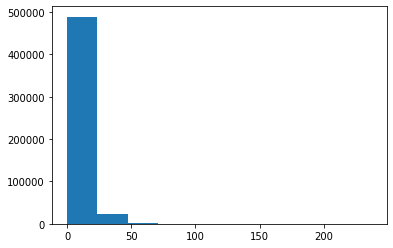

In [6]:
print(sequences[1:10])
sequence_lengths = np.array([
    len(seq) for seq in sequences
])

max_seq_len = max(sequence_lengths)
word_count = len(word_to_index)

print(f'[+] Max Sequence Length: {max_seq_len}')
print(f'[+] Word Count: {word_count}')

sequence_lengths = np.array([
    len(seq) for seq in sequences
])
%matplotlib inline
plt.hist(sequence_lengths)

In [7]:
print(f'[+] {len(word_to_index)} words found in {merged_questions_path}')

print('[+] Word Map Subset:\n{')
for _, (word, index) in zip(range(40), word_to_index.items()):
    print('\t{}: {}'.format(word, index))
print('\t...\n}')

[+] 78630 words found in /home/das-hund/PycharmProjects/autoencoders/data/merged.csv
[+] Word Map Subset:
{
	the: 1
	what: 2
	is: 3
	how: 4
	i: 5
	a: 6
	to: 7
	in: 8
	do: 9
	of: 10
	are: 11
	and: 12
	can: 13
	for: 14
	you: 15
	why: 16
	my: 17
	best: 18
	it: 19
	on: 20
	does: 21
	or: 22
	which: 23
	if: 24
	be: 25
	some: 26
	have: 27
	that: 28
	with: 29
	get: 30
	should: 31
	an: 32
	from: 33
	your: 34
	india: 35
	will: 36
	when: 37
	people: 38
	who: 39
	like: 40
	...
}


#### Sequence Generation

#### Pad Sequences

In [8]:
# Need to change padding to post. Also look at truncating arg.
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post')

In [9]:
print(padded_sequences[0:5])
padded_sequences.shape

[[   23    11     1   206    18   853   177     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    2     3    19    40   144     6  1059     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [   16    55  1475   504     1 14037     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    4    13     5     9   275 44653   356    10  1033    20    17   239
      0     0     0     0     0     0     0     0     0     0     0     0
      0]
 [    2    11    26  1312   595  3761     7   165    37   985 44654 14038
      0     0     0     0     0     0     0     0     0     0     0     0
      0]]


(512000, 25)

## Model Architecture

Note I'm not using the GLOVE embeddings here.
That would make it difficult to transition this
model to protein sequences. 

In [10]:
def build_autoencoder(embedding_dim, token_count, 
                      max_seq_len, latent_dim, 
                      intermediate_dim):
    encoder_input = Input(shape=(max_seq_len,), name='encoder_input')
    embedding = Embedding(
        token_count, embedding_dim,
        input_length=(max_seq_len,), name='embedding'
    )(encoder_input)
    latent = LSTM(
        latent_dim, return_sequences=True, name='latent'
    )(embedding)
    
    #decoded = RepeatVector(max_seq_len, name='rv')(latent)
    decoded = LSTM(
        max_seq_len, return_sequences=False, name='decoded'
    )(latent)

    #autoencoder = Model(inputs, decoded)
    #encoder = Model(encoder_input, encoded)

    autoencoder = Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [11]:
# This model is converging, albeit slowly
def build_embedding_trainer(embedding_dim, token_count, 
                            max_seq_len, latent_dim, 
                            intermediate_dim):
    encoder_input = Input(shape=(max_seq_len,), name='encoder_input')
    embedding = Embedding(
        token_count, embedding_dim, 
        input_length=(max_seq_len,), name='embedding'
    )(encoder_input)
    f = Flatten()(embedding)
    encoded_intermediate = Dense(
        intermediate_dim, activation='relu', name='encoded_intermediate'
    )(f)
    latent = Dense(
        latent_dim, activation='relu', name='latent'
    )(encoded_intermediate)
    decoded_intermediate = Dense(
        intermediate_dim, activation='relu', name='decoded_intermediate'
    )(latent)
    output = Dense(
        max_seq_len, activation='relu', name='output'
    )(decoded_intermediate)
    ae = Model(encoder_input, output)
    ae.compile(optimizer='adadelta', loss='mse')
    return ae

In [12]:
from keras.layers.advanced_activations import ELU
def build_model(max_seq_len, embedding_dim, token_count,
                batch_size, intermediate_dim, 
                latent_dim, embedding_layer, epsilon_std=0.1):
    # ENCODER
    encoder_input = Input(shape=(max_seq_len,), name='encoder_input')
    embedding = Embedding(
        token_count, embedding_dim, 
        input_length=(max_seq_len,), name='embedding',
        weights=e_layer.get_weights(), trainable=False
    )(encoder_input)
    encoder_intermediate_rnn = LSTM(
        intermediate_dim, name='encoder_intermediate_rnn'
    )(embedding)
    #reweight = Dense(
    #    intermediate_dim, activation='linear', name='reweight'
    #)(encoder_intermediate_rnn)
    #reweight = ELU()(reweight)
    
    # Z
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon
    z_mean = Dense(latent_dim, name='z_mean')(encoder_intermediate_rnn)
    z_log_sigma = Dense(latent_dim, name='z_log_sigma')(encoder_intermediate_rnn)
    z = Lambda(
        sampling, output_shape=(latent_dim,), name='z'
    )([z_mean, z_log_sigma])
    
    # DECODER
    # The way these layers are created makes the code confusing, 
    # but the point is that they have to be used multiple times.
    decoder_intermediate_rnn = LSTM(
        intermediate_dim, return_sequences=True, name='decoder_intermediate_rnn'
    )
    decoder_mean = LSTM(
        max_seq_len, return_sequences=False, name='decoder_mean'
    )
    
    # The RNN layers in keras have two options:
    # Return_sequences=True - returns the state of each cell
    # return_sequences=False - returns the state of the last cell
    # We are using the latter, but need to be able to feed the 
    # data into an LSTM with size intermediate_dim.
    repeat_z = RepeatVector(max_seq_len, name='repeat_z')(z)
    h_decoded = decoder_intermediate_rnn(repeat_z)
    out_decoder_mean = decoder_mean(h_decoded)
    
    # End to end
    vae = Model(encoder_input, out_decoder_mean)
    # Inputs to latent space
    encoder = Model(encoder_input, z_mean)
    
    # Decoder
    decoder_input = Input(shape=(latent_dim,))
    decoder_repeat = RepeatVector(max_seq_len, name='decoder_repeat')(decoder_input)
    decoder_h_decoded = decoder_intermediate_rnn(decoder_repeat)
    _out_decoder_mean = decoder_mean(decoder_h_decoded)
    generator = Model(decoder_input, _out_decoder_mean)
    
    def vae_loss(x, x_decoded):
        xent_loss = objectives.mse(x, x_decoded)
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = xent_loss + kl_loss
        return loss

    vae.compile(optimizer='rmsprop', loss=vae_loss)
    
    return vae, encoder, generator

In [13]:
MAX_SEQUENCE_LENGTH = MAX_SEQ_LEN
EMBED_DIM = 16
WORD_COUNT = word_count
BATCH_SIZE = 512
INTERMEDIATE_DIM = 16
LATENT_DIM = 8

embedding_trainer = build_embedding_trainer(
    embedding_dim=EMBED_DIM, 
    token_count=WORD_COUNT, 
    max_seq_len=MAX_SEQUENCE_LENGTH, 
    latent_dim=LATENT_DIM, 
    intermediate_dim=INTERMEDIATE_DIM
)

Instructions for updating:
Colocations handled automatically by placer.


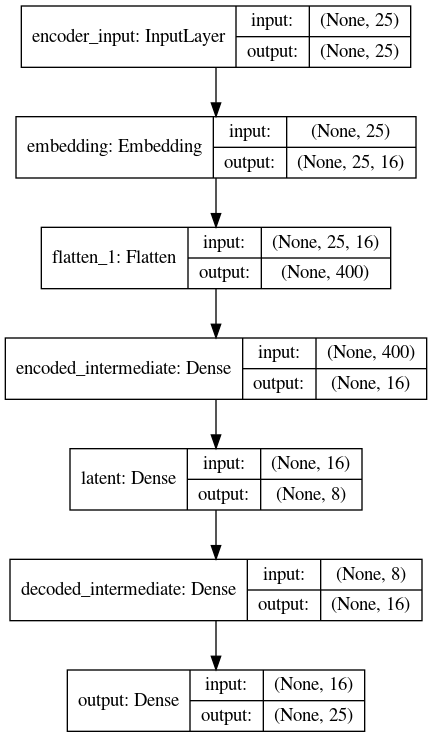

In [14]:
plot_model(embedding_trainer, show_shapes=True, show_layer_names=True, to_file='embedding_trainer.png')
Image(retina=True, filename='embedding_trainer.png')

In [15]:
#embedding_trainer.summary()

In [16]:
# TODO Try training the embedding with VAE loss
embedding_trainer.fit(
    padded_sequences, padded_sequences,
    epochs=512, batch_size=BATCH_SIZE
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/512
512000/512000 [==============================] - 5s 9us/step - loss: 17429844.7420
Epoch 2/512
512000/512000 [==============================] - 3s 7us/step - loss: 14267503.4935
Epoch 3/512
512000/512000 [==============================] - 4s 7us/step - loss: 12310836.4390
Epoch 4/512
512000/512000 [==============================] - 4s 7us/step - loss: 10900821.7885
Epoch 5/512
512000/512000 [==============================] - 4s 7us/step - loss: 10130685.5680
Epoch 6/512
512000/512000 [==============================] - 4s 7us/step - loss: 9577667.5840
Epoch 7/512
512000/512000 [==============================] - 4s 7us/step - loss: 9137069.7100
Epoch 8/512
512000/512000 [==============================] - 4s 7us/step - loss: 8765543.3010
Epoch 9/512
512000/512000 [==============================] - 4s 7us/step - loss: 8440662.1590
Epoch 10/512
512000/512000 [==============================] - 4s 7us/step - loss: 8145536.7135
Epoch 

512000/512000 [==============================] - 4s 7us/step - loss: 2694814.7988
Epoch 85/512
512000/512000 [==============================] - 4s 7us/step - loss: 2677232.5251
Epoch 86/512
512000/512000 [==============================] - 4s 7us/step - loss: 2662394.6309
Epoch 87/512
512000/512000 [==============================] - 4s 7us/step - loss: 2649921.0608
Epoch 88/512
512000/512000 [==============================] - 4s 7us/step - loss: 2636073.5133
Epoch 89/512
512000/512000 [==============================] - 4s 7us/step - loss: 2621639.6616
Epoch 90/512
512000/512000 [==============================] - 4s 7us/step - loss: 2606410.4109
Epoch 91/512
512000/512000 [==============================] - 4s 7us/step - loss: 2593516.4967
Epoch 92/512
512000/512000 [==============================] - 4s 7us/step - loss: 2579467.3563
Epoch 93/512
512000/512000 [==============================] - 4s 7us/step - loss: 2566561.9559
Epoch 94/512
512000/512000 [==============================] - 4

512000/512000 [==============================] - 4s 7us/step - loss: 1738091.2094
Epoch 170/512
512000/512000 [==============================] - 4s 7us/step - loss: 1732170.0994
Epoch 171/512
512000/512000 [==============================] - 4s 7us/step - loss: 1728936.3249
Epoch 172/512
512000/512000 [==============================] - 4s 7us/step - loss: 1721473.4193
Epoch 173/512
512000/512000 [==============================] - 4s 7us/step - loss: 1715414.7394
Epoch 174/512
512000/512000 [==============================] - 4s 7us/step - loss: 1709703.4279
Epoch 175/512
512000/512000 [==============================] - 4s 7us/step - loss: 1703014.5513
Epoch 176/512
512000/512000 [==============================] - 4s 7us/step - loss: 1698749.2431
Epoch 177/512
512000/512000 [==============================] - 4s 7us/step - loss: 1692534.8795
Epoch 178/512
512000/512000 [==============================] - 4s 7us/step - loss: 1688104.2491
Epoch 179/512
512000/512000 [=========================

512000/512000 [==============================] - 4s 7us/step - loss: 1455198.0462
Epoch 255/512
512000/512000 [==============================] - 4s 7us/step - loss: 1453237.7633
Epoch 256/512
512000/512000 [==============================] - 4s 7us/step - loss: 1451408.2963
Epoch 257/512
512000/512000 [==============================] - 4s 7us/step - loss: 1449932.0898
Epoch 258/512
512000/512000 [==============================] - 4s 7us/step - loss: 1447896.7372
Epoch 259/512
512000/512000 [==============================] - 4s 7us/step - loss: 1445870.9967
Epoch 260/512
512000/512000 [==============================] - 4s 7us/step - loss: 1445707.8369
Epoch 261/512
512000/512000 [==============================] - 4s 7us/step - loss: 1443779.4812
Epoch 262/512
512000/512000 [==============================] - 4s 7us/step - loss: 1442204.1765
Epoch 263/512
512000/512000 [==============================] - 4s 7us/step - loss: 1440217.8198
Epoch 264/512
512000/512000 [=========================

512000/512000 [==============================] - 4s 7us/step - loss: 1360367.9586
Epoch 340/512
512000/512000 [==============================] - 4s 7us/step - loss: 1360232.9248
Epoch 341/512
512000/512000 [==============================] - 4s 7us/step - loss: 1358446.9289
Epoch 342/512
512000/512000 [==============================] - 4s 7us/step - loss: 1357814.6077
Epoch 343/512
512000/512000 [==============================] - 4s 7us/step - loss: 1358876.0710
Epoch 344/512
512000/512000 [==============================] - 4s 7us/step - loss: 1357612.4445
Epoch 345/512
512000/512000 [==============================] - 4s 7us/step - loss: 1355921.4250
Epoch 346/512
512000/512000 [==============================] - 4s 7us/step - loss: 1355771.2716
Epoch 347/512
512000/512000 [==============================] - 4s 7us/step - loss: 1355989.3345
Epoch 348/512
512000/512000 [==============================] - 4s 7us/step - loss: 1354355.3216
Epoch 349/512
512000/512000 [=========================

512000/512000 [==============================] - 4s 7us/step - loss: 1314742.6818
Epoch 425/512
512000/512000 [==============================] - 4s 7us/step - loss: 1315700.5445
Epoch 426/512
512000/512000 [==============================] - 4s 7us/step - loss: 1313986.1832
Epoch 427/512
512000/512000 [==============================] - 4s 7us/step - loss: 1314038.0693
Epoch 428/512
512000/512000 [==============================] - 4s 7us/step - loss: 1314341.1267
Epoch 429/512
512000/512000 [==============================] - 4s 7us/step - loss: 1312706.0185
Epoch 430/512
512000/512000 [==============================] - 4s 7us/step - loss: 1311725.1854
Epoch 431/512
512000/512000 [==============================] - 4s 7us/step - loss: 1312117.9359
Epoch 432/512
512000/512000 [==============================] - 4s 7us/step - loss: 1310754.7311
Epoch 433/512
512000/512000 [==============================] - 4s 7us/step - loss: 1310303.0196
Epoch 434/512
512000/512000 [=========================

512000/512000 [==============================] - 4s 7us/step - loss: 1285679.0330
Epoch 510/512
512000/512000 [==============================] - 4s 7us/step - loss: 1285879.7314
Epoch 511/512
512000/512000 [==============================] - 4s 7us/step - loss: 1284943.3835
Epoch 512/512
512000/512000 [==============================] - 4s 7us/step - loss: 1284843.2669


In [17]:
e_layer = embedding_trainer.get_layer('embedding')
vae, encoder, generator = build_model(
    max_seq_len=MAX_SEQUENCE_LENGTH,
    embedding_dim=EMBED_DIM,
    token_count=WORD_COUNT,
    batch_size=BATCH_SIZE,
    intermediate_dim=INTERMEDIATE_DIM,
    latent_dim=LATENT_DIM,
    embedding_layer=e_layer,
    epsilon_std=0.3
)

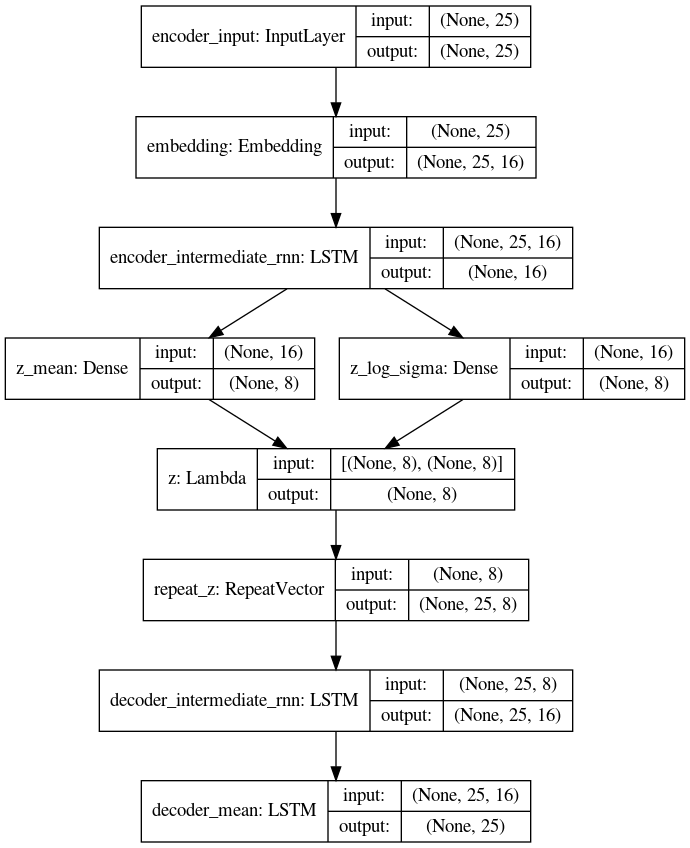

In [18]:
plot_model(vae, show_shapes=True, show_layer_names=True, to_file='vae.png')
Image(retina=True, filename='vae.png')

In [19]:
# InvalidArgumentError: Incompatible shapes: [256,237,237] vs. [256,237]
'''
InvalidArgumentError: Incompatible shapes: [256] vs. [32]
     [[{{node training/RMSprop/gradients/loss/decoder_mean_loss/mul_1_grad/BroadcastGradientArgs}}]]
     [[{{node loss/mul}}]]
'''
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 25)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 16)       1258080     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_intermediate_rnn (LSTM) (None, 16)           2112        embedding[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 8)            136         encoder_intermediate_rnn[0][0]   
__________________________________________________________________________________________________
z_log_sigm

In [21]:
history = vae.fit(
    padded_sequences, padded_sequences, 
    epochs=10, batch_size=BATCH_SIZE
)

Epoch 1/10
512000/512000 [==============================] - 55s 107us/step - loss: 19151747.9500
Epoch 2/10
512000/512000 [==============================] - 55s 107us/step - loss: 19151747.9410
Epoch 3/10
512000/512000 [==============================] - 55s 106us/step - loss: 19151747.8840
Epoch 4/10
512000/512000 [==============================] - 55s 107us/step - loss: 19151747.9520
Epoch 5/10
385536/512000 [=====================>........] - ETA: 13s - loss: 19165462.3347

KeyboardInterrupt: 